### CW_model_training.ipynb 

This is based on the original notebook by the main author of the paper (`RADIPOP_model_training.ipynb`).
Since I need to reuse it on new data, I might as well clean it up a bit. 


However, currently it is not finished... #TODO 

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import pickle
import numba
from typing import Literal, Union
from glob import glob
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, RocCurveDisplay
# see https://stackoverflow.com/questions/60321389/sklearn-importerror-cannot-import-name-plot-roc-curve

import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing  import StandardScaler


from sklearn.base import BaseEstimator, TransformerMixin
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr, pearsonr
from scipy.stats import ttest_ind
from collections import defaultdict
import seaborn as sns
import skopt
import time
import re 

import radipop_utils 
import radipop_utils.visualization
import radipop_utils.features
from radipop_utils.features import SpearmanReducerCont
import radipop_utils.utils
from radipop_utils.utils import get_files_dict_by_regex_pattern

import radipop_utils.data

from sklearn.metrics import mean_squared_error, mean_absolute_error




# load user/ system specific env variables:
from dotenv import dotenv_values, find_dotenv
config = dotenv_values(find_dotenv())  # load environment variables as dictionary

path = Path(os.path.abspath(radipop_utils.__file__))
RADIPOP_PACKAGE_ROOT = path.parent.parent



In [2]:

##------  You will likely need to change this 
DATA_ROOT_DIRECTORY = Path(config["DATA_ROOT_DIRECTORY"])
OUTDIR = DATA_ROOT_DIRECTORY / "radiomics" / "Dataset125_LSS" 
DATASET = "Dataset125_LSS"
RADIOMICS_OPTION = "radipop_111"
NUM_SEARCHES = 20
SEARCH_SCORING_METRIC = "r2"  # "neg_root_mean_squared_error"  "r2"
SAVE_RESULTS = False
##-----------

### Preparing the the data: 
- load radiomics and HVPG values 
- utilize our custom split (previously defined and stratified on sex, scanner, status)
- normalized the data

In [3]:
# load features and combine with predicted values: 

df_Tr, df_iTs, df_eTs = radipop_utils.data.load_HVPG_values_and_radiomics(DATASET=DATASET, RADIOMICS_OPTION=RADIOMICS_OPTION, DATA_ROOT_DIRECTORY=DATA_ROOT_DIRECTORY)
print(f"{len(df_Tr)=}, {len(df_eTs)=}, {len(df_iTs)=}")

len(df_Tr)=298, len(df_eTs)=50, len(df_iTs)=50


In [4]:
# display(df_Tr)
# display(df_iTs)
# display(df_eTs)

In [5]:
split_indices_CV5_Tr = radipop_utils.data.extract_CV_indices(df_Tr)

X_Tr, Y_Tr, X_iTs, Y_iTs, X_eTs, Y_eTs = radipop_utils.data.preprocess_data(df_Tr, df_iTs, df_eTs, normalize_X=True)    

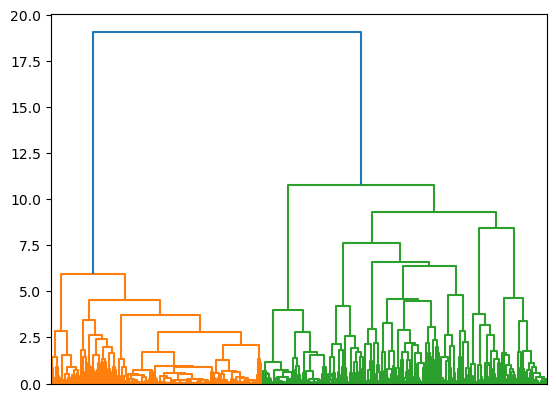

In [6]:
#plot dendrogram
corr = spearmanr(X_Tr).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# plt.matshow(corr)
# plt.show()

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
plt.figure()
dendro = hierarchy.dendrogram(
    dist_linkage, no_labels=True
)

In [7]:
#decide on a rought range for the cut parameters for dendrogram
split_params = [0.5, 0.75, 1, 2.75,  5, 7.5, 10]
for split_param in split_params:
    selector = SpearmanReducerCont(split_param=split_param)
    print(f"Selected features at height {split_param}:", len(selector.fit(X_Tr, Y_Tr).selected_features))
    
    

Selected features at height 0.5: 234
Selected features at height 0.75: 150
Selected features at height 1: 104
Selected features at height 2.75: 29
Selected features at height 5: 9
Selected features at height 7.5: 6
Selected features at height 10: 3


#### Fit on `Tr` data with CV and estimate best model + hyper parameters

In [8]:
# Bounds for hyperparameters
param_bounds_rf = {
    'feature_selection__split_param' : skopt.space.Real(1,5, prior = "uniform"),
    'regression' : [RandomForestRegressor(random_state=2023)],
    'regression__n_estimators': skopt.space.Integer(100, 2000),
    'regression__max_depth': skopt.space.Integer(1, 50),
    'regression__min_samples_split': skopt.space.Integer(2, 25)#,
}


param_bounds_en = {
                 'feature_selection__split_param' : skopt.space.Real(1,5, prior = "uniform"),
                 'regression' : [ElasticNet(random_state=2023)],
                 'regression__alpha': skopt.space.Real(0.0001, 1.0, 'uniform'),
                 'regression__l1_ratio': skopt.space.Real(0, 1.0, 'uniform')
}


In [9]:
#create a pipeline
reg_RF = Pipeline([
  #('scaler', StandardScaler()),  
  ('feature_selection', SpearmanReducerCont()),
  ('regression', RandomForestRegressor())
]) 

# cv5 = KFold(5, shuffle=True, random_state=2023)



In [10]:


#try out models
opt0 = skopt.BayesSearchCV(
    reg_RF,
    [(param_bounds_en, NUM_SEARCHES), (param_bounds_rf, NUM_SEARCHES)],
    cv=split_indices_CV5_Tr,
    scoring=SEARCH_SCORING_METRIC,
    verbose=True,
    random_state=2023,
    n_jobs = 6
)
opt0.fit(X_Tr, Y_Tr)

display(opt0.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+00, tolerance: 4.617e-01
  model = cd_fast.enet_coordinate_descent(
/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.107e-01, tolerance: 3.536e-01
  model = cd_fast.enet_coordinate_descent(
/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+02, tolerance: 3.536e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.858e+02, tolerance: 4.095e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.344e+02, tolerance: 4.617e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+03, tolerance: 7.005e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e+03, tolerance: 4.095e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/cwatzenboeck/anaconda3/envs/pyt3-9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.516e+03, tolerance: 7.005e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

OrderedDict([('feature_selection__split_param', 1.0),
             ('regression',
              ElasticNet(alpha=0.9435871670614078, l1_ratio=1.0, random_state=2023)),
             ('regression__alpha', 0.9435871670614078),
             ('regression__l1_ratio', 1.0)])

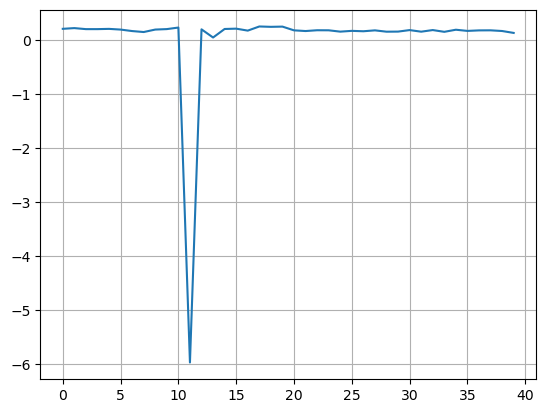

In [11]:
cv_res = pd.DataFrame(opt0.cv_results_)
cv_res
cv_res.iloc[:, :].reset_index().loc[:, "mean_test_score"].plot()
plt.grid()



In [12]:
cv_res



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__split_param,param_regression,param_regression__alpha,param_regression__l1_ratio,param_regression__max_depth,param_regression__min_samples_split,param_regression__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.955612,0.274197,0.000460,0.000032,2.743571,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.387402,0.128819,NaN,NaN,NaN,{'feature_selection__split_param': 2.743571433...,0.297390,0.100177,0.251089,0.185337,0.206686,0.208136,0.066315,7
1,3.664954,0.175967,0.000466,0.000076,3.284402,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.985515,0.703889,NaN,NaN,NaN,{'feature_selection__split_param': 3.284402090...,0.263824,0.174915,0.290114,0.157732,0.220450,0.221407,0.050471,5
2,3.858914,0.095431,0.000407,0.000031,4.149169,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.721623,0.930024,NaN,NaN,NaN,{'feature_selection__split_param': 4.149169393...,0.243352,0.136737,0.291184,0.115503,0.225269,0.202409,0.066250,12
3,3.926795,0.157921,0.000441,0.000041,2.883225,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.324929,0.066263,NaN,NaN,NaN,{'feature_selection__split_param': 2.883225269...,0.292007,0.072773,0.262698,0.186038,0.198842,0.202471,0.075827,11
4,4.202653,0.156315,0.000439,0.000034,3.80773,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.975746,0.854681,NaN,NaN,NaN,{'feature_selection__split_param': 3.807729785...,0.259746,0.159653,0.269631,0.121148,0.225095,0.207055,0.057697,8
5,4.478855,0.423979,0.000522,0.000064,2.24902,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.504889,0.786739,NaN,NaN,NaN,{'feature_selection__split_param': 2.249020143...,0.283490,0.013976,0.234134,0.209243,0.230556,0.194280,0.093377,15
6,4.108378,0.322873,0.000479,0.000055,4.406906,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.261723,0.06709,NaN,NaN,NaN,{'feature_selection__split_param': 4.406905681...,0.208117,0.108407,0.265366,0.063524,0.188170,0.166717,0.072048,30
7,4.331275,0.209564,0.000429,0.000018,4.592474,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.556117,0.92798,NaN,NaN,NaN,{'feature_selection__split_param': 4.592474169...,0.206492,-0.058499,0.276356,0.102009,0.217870,0.148846,0.117925,37
8,4.519911,0.308696,0.000450,0.000039,3.186457,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.237075,0.058609,NaN,NaN,NaN,{'feature_selection__split_param': 3.186456979...,0.291513,0.048667,0.297975,0.141788,0.192013,0.194391,0.093990,14
9,4.416307,0.257447,0.000452,0.000010,3.707944,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.58116,0.544714,NaN,NaN,NaN,{'feature_selection__split_param': 3.707943921...,0.272307,0.150191,0.289525,0.112533,0.190268,0.202965,0.068447,10


In [13]:
cv_res_sorted = cv_res.sort_values("rank_test_score")
pd.DataFrame(list(cv_res_sorted["params"]))
#cv_res_sorted[["params", "mean_test_score"]]



,feature_selection__split_param,regression,regression__alpha,regression__l1_ratio,regression__max_depth,regression__min_samples_split,regression__n_estimators
0,1.000000,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.943587,1.000000,NaN,NaN,NaN
1,1.000000,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.901154,1.000000,NaN,NaN,NaN
2,1.000000,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.843921,1.000000,NaN,NaN,NaN
3,1.000000,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",1.000000,0.015915,NaN,NaN,NaN
4,3.284402,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.985515,0.703889,NaN,NaN,NaN
5,1.000000,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.743924,0.000000,NaN,NaN,NaN
6,2.743571,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.387402,0.128819,NaN,NaN,NaN
7,3.807730,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.975746,0.854681,NaN,NaN,NaN
8,3.614311,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.533968,0.649217,NaN,NaN,NaN
9,3.707944,"ElasticNet(alpha=0.9435871670614078, l1_ratio=...",0.581160,0.544714,NaN,NaN,NaN


#### save model trained on the whole training data set and optimal paramters

In [14]:


idx_best_EN_model = cv_res["mean_test_score"][:NUM_SEARCHES].argmax()
idx_best_RF_model = cv_res["mean_test_score"][NUM_SEARCHES:].argmax() + NUM_SEARCHES

if SAVE_RESULTS:
    os.makedirs(OUTDIR / "regression" / RADIOMICS_OPTION, exist_ok=True)
    dst = OUTDIR / "regression" / RADIOMICS_OPTION / f"Bayesian_results_{NUM_SEARCHES}_iterations_RFvsEN.xlsx"
    cv_res.to_excel(dst)
    print("Saved hyperparams search to : ", dst)

    
    save_dst = OUTDIR / "regression" / RADIOMICS_OPTION
    
    # save optimal parameters as yaml: 
    dst = save_dst / "SpearmanRed1_RF_opt_params.yml"
    data = {**cv_res.iloc[idx_best_RF_model, :].params}
    if "regression" in data: 
        data.pop("regression")
    with open(dst, 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)
        print("saved params to ", dst)
        

    # save optimal parameters as yaml: 
    dst = save_dst / "SpearmanRed1_EN_opt_params.yml"
    data = {**cv_res.iloc[idx_best_EN_model, :].params} # make copy to keep original dict unchanged
    if "regression" in data: 
        data.pop("regression")
    with open(dst, 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)
        print("saved params to ", dst)
        

    #---- set best performing en/rf models
    #create a pipeline
    reg_RF = Pipeline([
    #('scaler', StandardScaler()),  
    ('feature_selection', SpearmanReducerCont()),
    ('regression', RandomForestRegressor())
    ]) 
    #Set params
    np.random.seed(2023)
    reg_RF.set_params(**cv_res.iloc[idx_best_RF_model, :].params)
    reg_RF.fit(X_Tr, Y_Tr)
    dst = save_dst / f"SpearmanRed1_RF_opt.p"
    with open(dst, "wb") as fp:
        pickle.dump(reg_RF, fp)
        print("Saved model to ", dst)


    #create a pipeline
    reg_EN = Pipeline([
    #('scaler', StandardScaler()),  
    ('feature_selection', SpearmanReducerCont()),
    ('regression', ElasticNet())
    ]) 
    reg_EN.set_params(**cv_res.iloc[idx_best_EN_model, :].params)
    reg_EN.fit(X_Tr, Y_Tr)
    dst = save_dst / f"SpearmanRed1_EN_opt.p"
    with open(dst, "wb") as fp:
        pickle.dump(reg_EN, fp)
        print("Saved model to ", dst)
